In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import cluster
import sklearn.metrics
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import entropy
from numpy.linalg import pinv
import operator
import itertools
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import *
import scipy.spatial.distance as ssd
import scipy

The purpose of this notebook is to create a pipeline for clustering cells based on their equivalence class counts and visualizing the produced labels. First, we define several helpful functions to easily do kmeans, spectral clustering, NMF, t-SNE, and a variety of distance functions (e.g. Shannon-Jensen).

In [1]:
# Functions that are helpful for analysis

# obtain labels via kmeans
def jz_kmeans(X,k,num_iter=50):
    k_means = cluster.KMeans(n_clusters=k,max_iter=num_iter,precompute_distances=True)
    k_means.fit(X)
    labels = k_means.labels_
    return labels

# obtain labels via spectral clustering
def jz_spectral(X,k,D):
    # Compute pairwise distances
    #D = pairwise_distances(X,metric=dist_funct,n_jobs=nj)
    if D[1,1] < 1: D = np.exp(-D**2) # Convert distance to similarity matrix
    spectral = cluster.SpectralClustering(n_clusters=k,affinity='precomputed')
    spectral.fit(D)
    labels = spectral.labels_
    return labels,D

# Hierarchical clustering (generate linkage matrix encoding hierarchical clustering result)
def jz_hierclust(D):
    D_sym = 0.5*D+0.5*D.T
    # convert the redundant n*n square matrix form into a condensed nC2 array
    # distArray[{n choose 2}-{n-i choose 2} + (j-i-1)] is the distance between points i and j
    distArray = ssd.squareform(D_sym)
    z = linkage(distArray,method='complete')
    return z

# Given a linkage matrix, return cluster labels (k clusters)
def jz_linkage_to_labels(z,k):
    return fcluster(z,k,criterion='maxclust')

# Bicluster matrix R into k clusters
def jz_bicluster(R,k):
    model = SpectralCoclustering(n_clusters=k, random_state=0)
    model.fit(R)
    plot_biclusters(R,model.row_labels_,model.column_labels_)
    return model.row_labels_,model.column_labels_

# Plot biclusters:
def plot_biclusters(R,row_labels,col_labels):
    fit_data = R[np.argsort(row_labels)]
    fit_data = fit_data[:, np.argsort(col_labels)]
    plt.figure(figsize=(15,10))
    plt.matshow(fit_data, cmap=plt.cm.Blues)
    plt.title("After biclustering; rearranged to show biclusters")
    plt.show()

# NMF
def jz_NMF(X,n_topics=9):
    nmf = NMF(n_components=n_topics)
    nmf.fit(X)
    pinv_of_dict=pinv(nmf.components_)
    NMF_rep = np.transpose(pinv_of_dict)*np.transpose(X)
    return np.transpose(NMF_rep)

# obtain two major directions from t-SNE
def jz_tSNE(X):
    tsne = manifold.TSNE(n_components=2, random_state=0);
    X_tsne = tsne.fit_transform(X);
    return X_tsne

# Distance metrics (input: X with m samples, output: m-by-m distance matrix)
def shannon_jensen(p, q):
    m=0.5*p+0.5*q
    p = np.transpose(p[p > 0])
    q = np.transpose(q[q > 0])
    m = np.transpose(m[m > 0])
    return np.sqrt(entropy(m)-0.5*entropy(q)-0.5*entropy(p))

# Plot function with colors corresponding to labels (first two columns of X)
def jz_plot(X,labels):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15,10))
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        plt.scatter(X[ind,0],X[ind,1],c=np.random.rand(3))

#Compute the error rates of two classification schemes.
#Rather than going over m! possibilities where m is the number of classes
#this uses the heuristic of comparing the i th largest cluster of on labeling scheme
#with the i th largest cluster of the other labelling scheme
def compare_labels(label1, label2):
    # quality control.. make sure inputs are np arrays and their lengths are equal
    nplabel1=np.array(label1)
    nplabel2=np.array(label2)
    assert len(label1)==len(label2)
    unique_labels1=np.unique(nplabel1)
    unique_labels2=np.unique(nplabel2)
    # Create two dictionaries that count the number of each unique label in the two label sets
    num_entries1={}
    num_entries2={}
    for label in unique_labels1:
        num_entries1[label] = len(nplabel1[nplabel1==label])
    for label in unique_labels2:
        num_entries2[label] = len(nplabel2[nplabel2==label])
    sorted_label1 = sorted(num_entries1.items(), key=operator.itemgetter(1))
    sorted_label2 = sorted(num_entries2.items(), key=operator.itemgetter(1))
    # Find and return the sum of the differences between the ith largest labelings for label1, label2
    difference=0
    for index in xrange(len(sorted_label1)):
         set1= set(np.flatnonzero(nplabel1==sorted_label1[index][0]))
         set2= set(np.flatnonzero(nplabel2==sorted_label2[index][0]))
         difference+=len(set1.symmetric_difference(set2))
    return difference/2

#gets max weight matching of a biparetite graph with row_label x column_label
#where the weight is given by the weight_matrix
def get_max_wt_matching(row_label,column_label, weight_matrix):
    # Create a bipartite graph where each group has |unique labels| nodes
    G = nx.complete_bipartite_graph(len(row_label), len(column_label))
    # Weight each edge by the weight in weight  matrix.. 
    for u,v in G.edges():
        G[u][v]["weight"]=weight_matrix[u,v-len(row_label)]
    # Perform weight matching using Kuhn Munkres
    H=nx.max_weight_matching(G)
    max_wt=0
    for u,v in H.items():
        max_wt+=G[u][v]["weight"]/float(2)
    return max_wt

#Plot heatmap
def get_heatmap(data_matrix, row_labels, column_labels, ttl):
    plt_shape = (int(data_matrix.shape[0]*1.25),data_matrix.shape[1])
    fig, ax = plt.subplots(figsize=plt_shape)
    heatmap = ax.pcolor(data_matrix, cmap=plt.cm.Blues)
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data_matrix.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(data_matrix.shape[1])+0.5, minor=False)
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)
    plt.title(ttl+"\n",fontsize=14)
    plt.colorbar(heatmap)
    plt.show()
    
-
    
# obtain two major directions from MDS
def vn_MDS(D):
    mds = manifold.MDS(n_components=2, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=12, random_state=None, dissimilarity='precomputed');
    X_mds = mds.fit_transform(D);
    return X_mds
# obtain two major directions from MDS
def vn_ICA(X):
    ica = decomposition.FastICA(n_components=2)
    X_mds = ica.fit_transform(X);
    return X_mds

First, load the data. We use Zeisel et al.'s 3005 brain cells. There should be 342812 equivalence classes total. (Initial processing with Kallisto already done).

In [3]:
# Load data
with open('/data/SS_RNA_seq/Code/sparse_eq_class.dat', 'rb') as infile:
    X = pickle.load(infile)
truth_9 = np.loadtxt('/data/SS_RNA_seq/Code/clustering_on_reads/metadata/cell_group_num_3005.txt',dtype=str)
truth_47 = np.loadtxt('/data/SS_RNA_seq/Code/clustering_on_reads/metadata/cell_subclass_3005.txt',dtype=str)
truth_tissue = np.loadtxt('/data/SS_RNA_seq/Code/clustering_on_reads/metadata/cell_tissue_3005.txt',dtype=str)

# Sanity checks on dimensions of loaded data:
print np.shape(X)
print len(truth_9)

(3005, 342812)
3005


Running t-SNE on the entire data

In [63]:
%matplotlib inline
X_tsne = jz_tSNE(X)

First few plots: t-SNE on the data and try a variety of labels provided by Zeisel et al.: 1) 47 labels they generated for all subclasses ("(none)" is also a subclass), 3) tissue where certain cells were extracted.

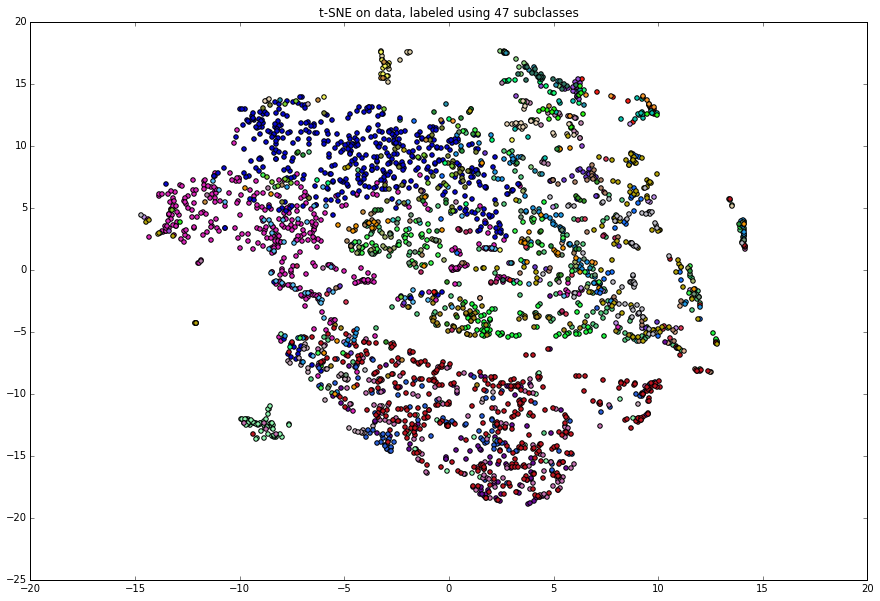

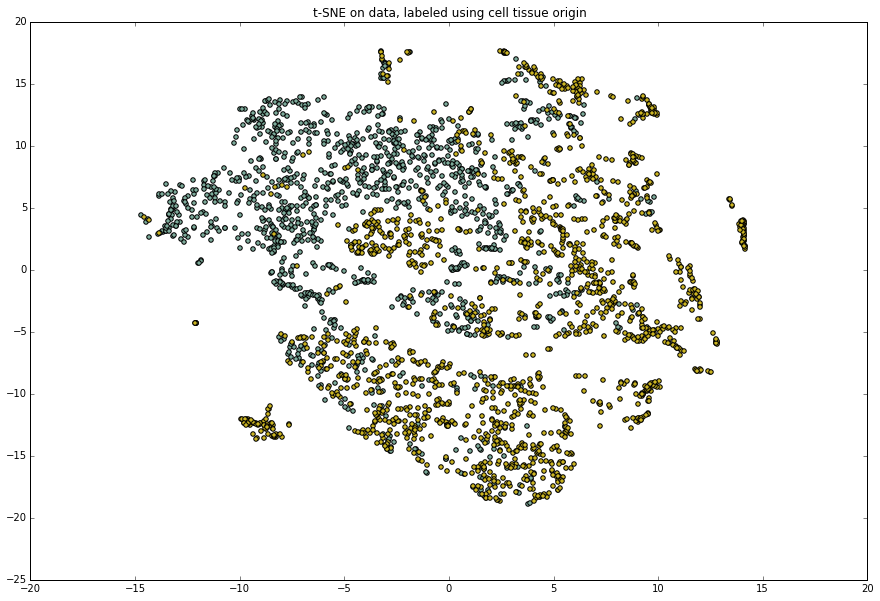

In [113]:
jz_plot(X_tsne,truth_47)
plt.title('t-SNE on data, labeled using 47 subclasses')
jz_plot(X_tsne,truth_tissue)
plt.title('t-SNE on data, labeled using cell tissue origin')

Generate k-means labels for k=9. Compare against the labels the authors generated for the 9 major classes.

In [35]:
#running kmeans with 9 clusters with 50 iterations
k = 9
labels9 = jz_kmeans(X,k)

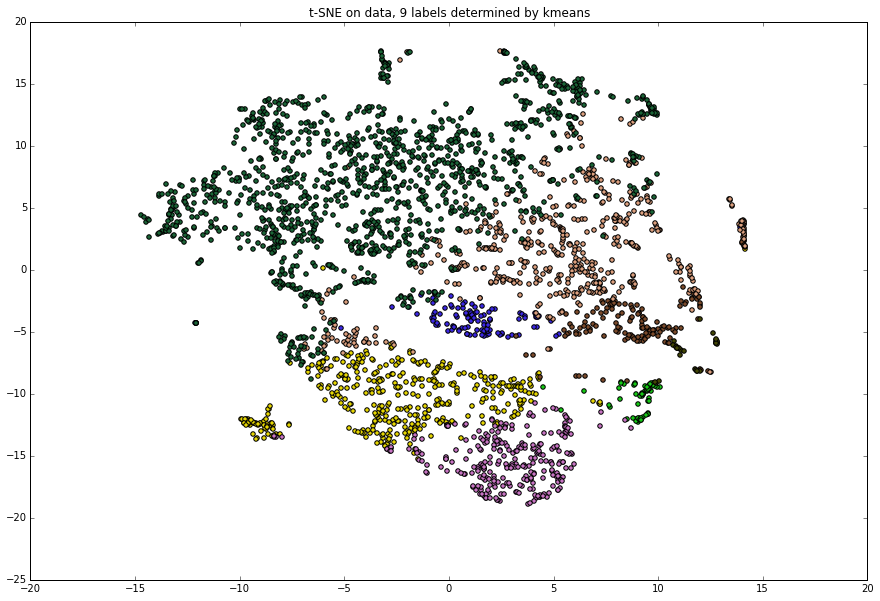

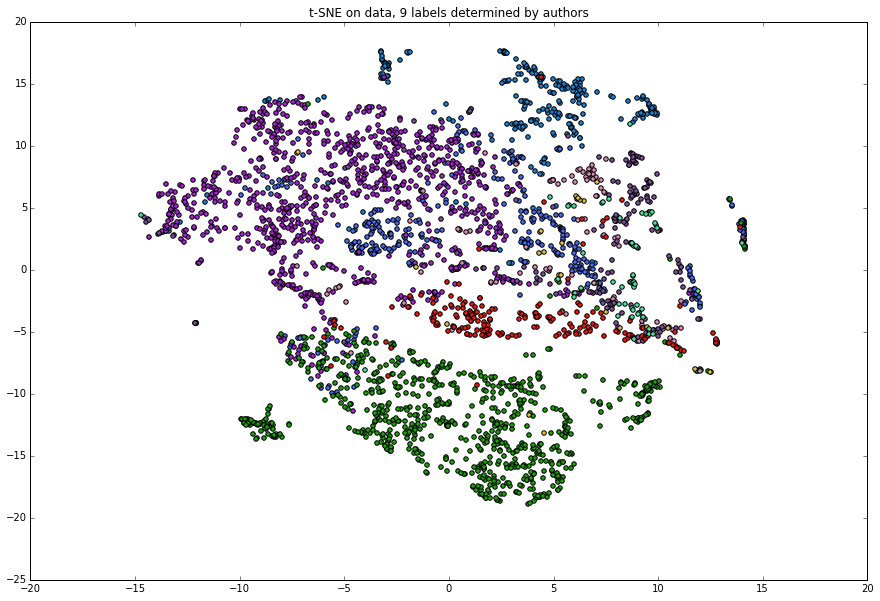

In [36]:
#Plot clusters returned by k-means with k=9
jz_plot(X_tsne,labels9)
plt.title('t-SNE on data, 9 labels determined by kmeans')
jz_plot(X_tsne,truth_9)
plt.title('t-SNE on data, 9 labels determined by authors')

Perform NMF on the dataset

In [38]:
%matplotlib inline
X_NMF = jz_NMF(X,n_topics=2)

We separate the cells of types 1-3, from those of types 4-9. The clusters obtained are as shown 

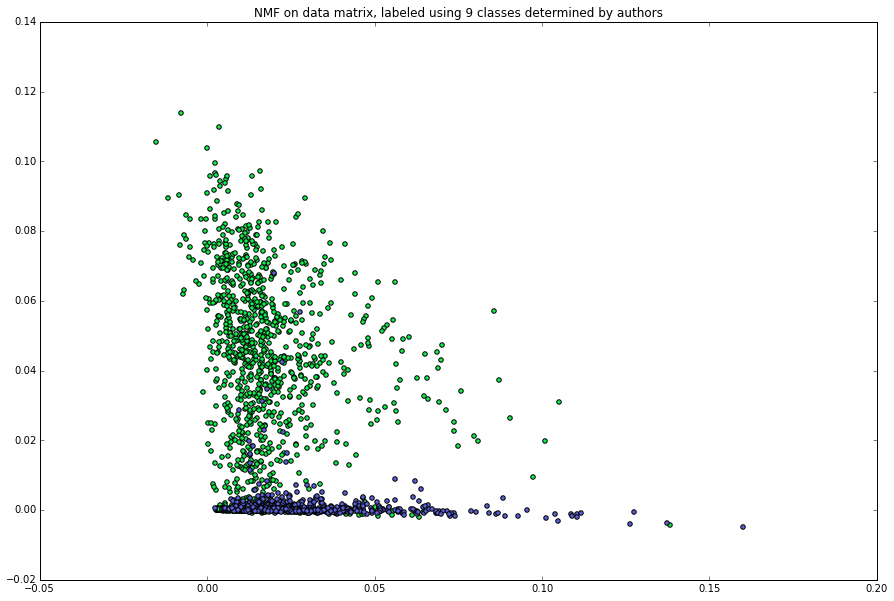

In [84]:
truth_s4=np.loadtxt('/data/SS_RNA_seq/Code/clustering_on_reads/metadata/cell_group_num_3005.txt',dtype=str)
truth_s4[truth_s4<='4']='0'
truth_s4[truth_s4>'4']='1'
jz_plot(X_NMF,truth_s4)
plt.title('NMF on data matrix, labeled using 9 classes determined by authors')

This clustering makes sense when viewing the bar chart from the paper which shows that the first 3 types of cells are much closer than the other 6 classes

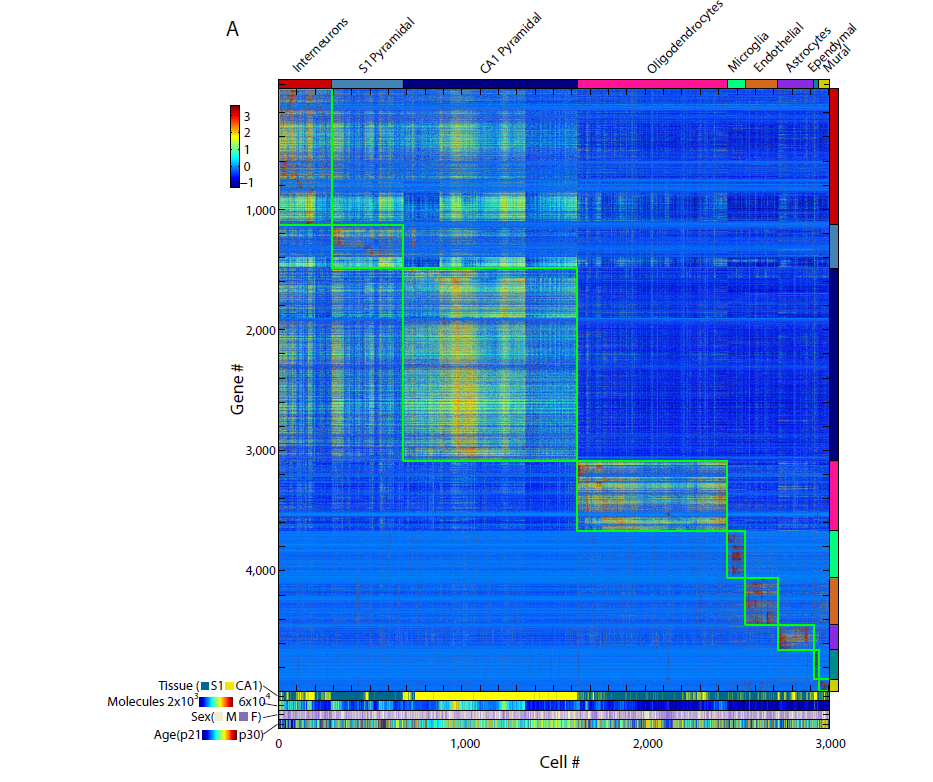

In [86]:
from IPython.display import Image
Image('Zeisel.png')

Generate spectral clustering labels for k=2 and k=9. Need to generate a distance matrix first, and we chose to use Shannon-Jensen entropy for pairwise distances.

In [103]:
# Load precomputed distance matrix
with open('/data/SS_RNA_seq/Code/pairwise_jensen_shannon_divergence.dat', 'rb') as infile:
    D = pickle.load(infile)
# Spectral clustering for k=2
labels_spectral_2, similarity_matrix_l1=jz_spectral(X,2,D)
# Spectral clustering for k=9
labels_spectral_9, similarity_matrix_l1=jz_spectral(X,9,D)

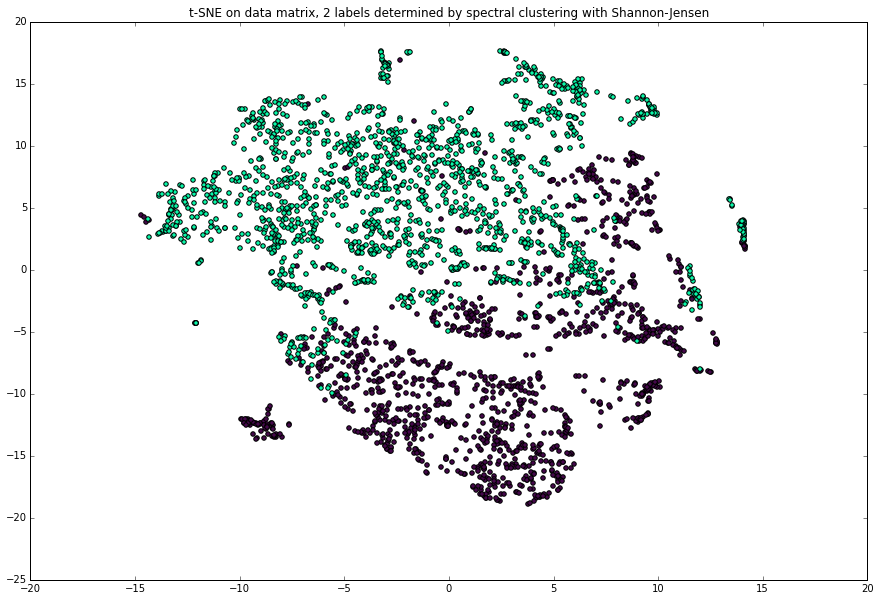

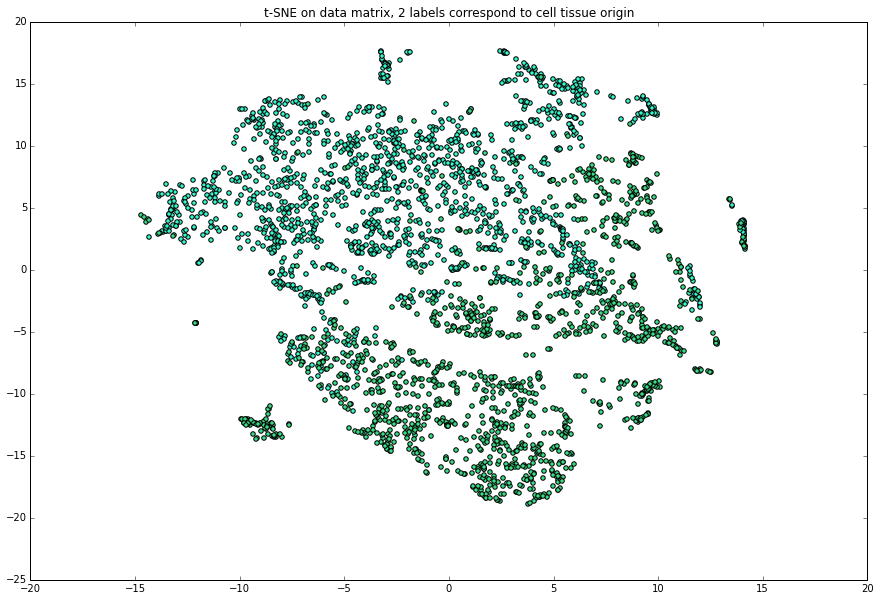

In [165]:
#Plot spectral clustering for 2 clusters from the 9 clusters
truth_ge4=np.zeros(truth_9.shape)
truth_ge4[truth_9>='4']=1
jz_plot(X_tsne,labels_spectral_2)
plt.title('t-SNE on data matrix, 2 labels determined by spectral clustering with Shannon-Jensen')
jz_plot(X_tsne,truth_ge4)
plt.title('t-SNE on data matrix, 2 labels correspond to cell tissue origin')

We now compute the error rates that the spectral clustering obtains when clustering classes 1-3 from classes 4 to 9. 

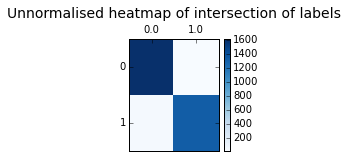

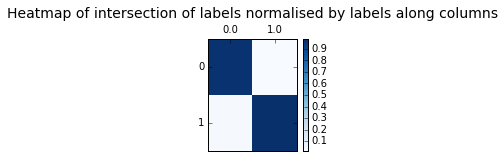

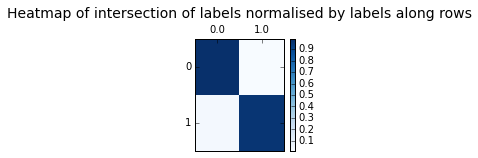

Error rates if best cluster index is picked row-wise : 2.26289517471%.
Error rates if best cluster index is picked column-wise : 2.26289517471%.
Error rates if best cluster index is picked using the Hungarian Algorithm : 2.26289517471%.


In [162]:
analyse_labeling_schemes(truth_ge4,labels_spectral_2)

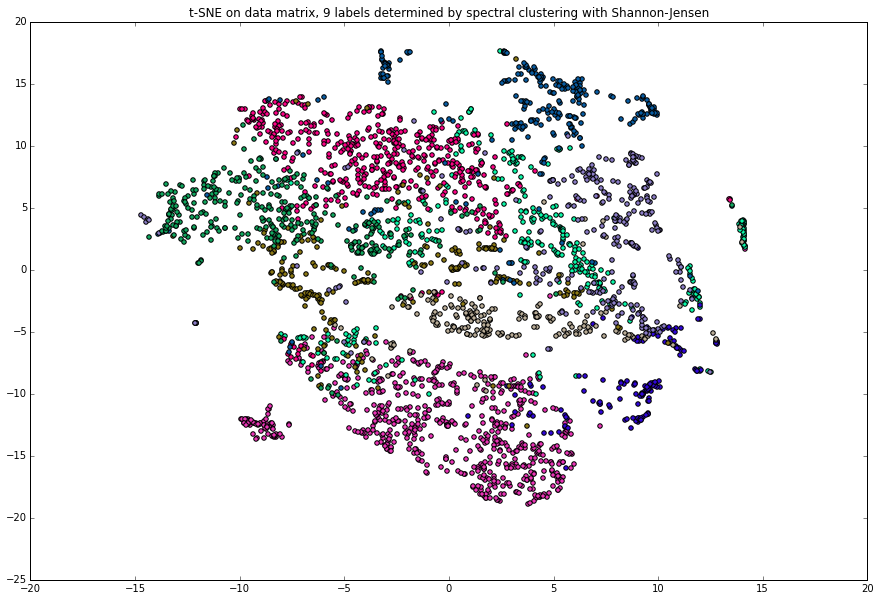

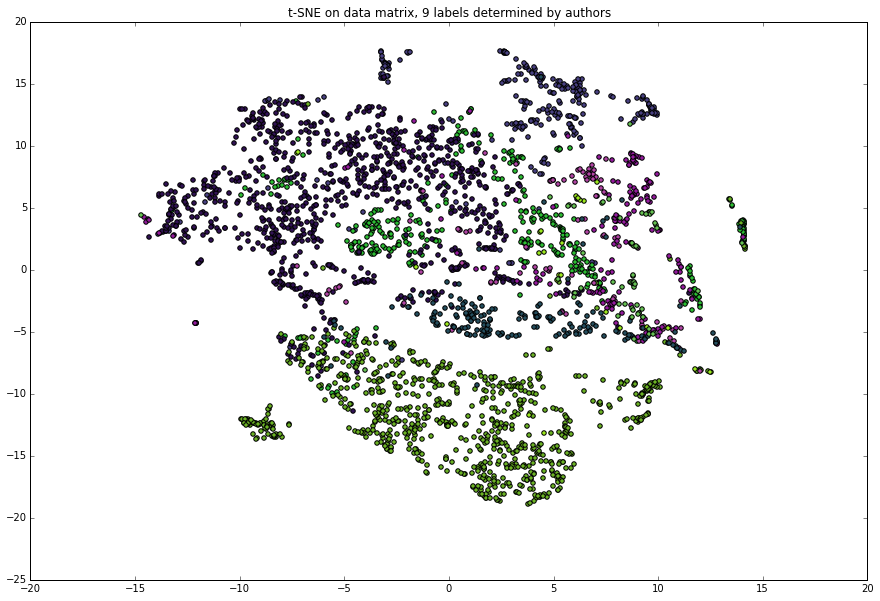

In [104]:
#Plot spectral clustering for 9 clusters
jz_plot(X_tsne,labels_spectral_9)
plt.title('t-SNE on data matrix, 9 labels determined by spectral clustering with Shannon-Jensen')
jz_plot(X_tsne,truth_9)
plt.title('t-SNE on data matrix, 9 labels determined by authors')

We now compute the error rates that the spectral clustering obtains when clustering all 9 classes.

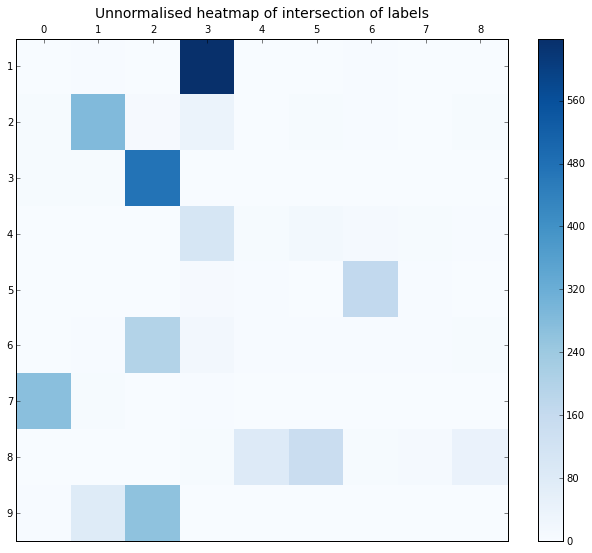

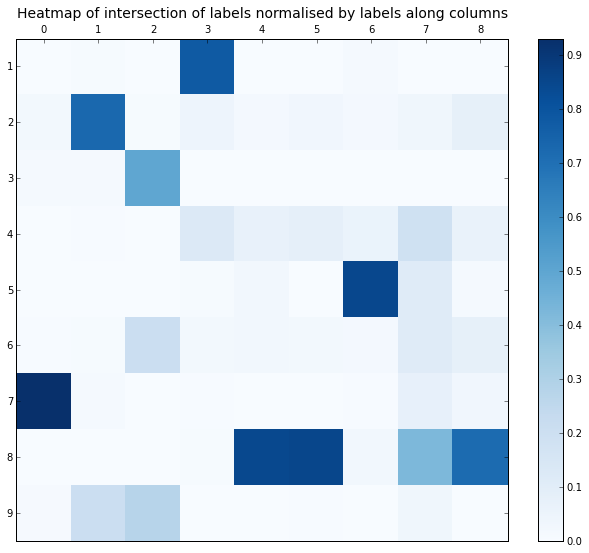

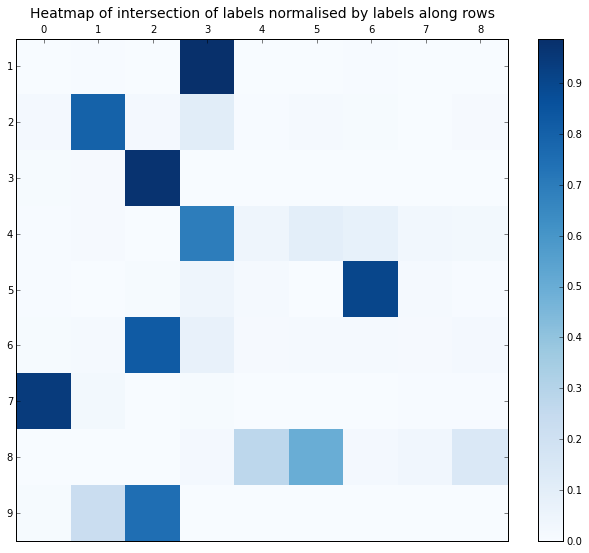

Error rates if best cluster index is picked row-wise : 29.4176372712%.
Error rates if best cluster index is picked column-wise : 15.1081530782%.
Error rates if best cluster index is picked using the Hungarian Algorithm : 33.544093178%.


In [105]:
analyse_labeling_schemes(labels_spectral_9,truth_9)

We next repeat the entire experiment using total-variation distance rather than Jensen-Shannon distances.

In [91]:
with open('/data/SS_RNA_seq/Code/pairwise_manhattan_distances.dat', 'rb') as infile:
    Dl1 = pickle.load(infile)
# Spectral clustering for k=2
labels_spectral_l1_2, similarity_matrix_l1=jz_spectral(X,2,Dl1)
# Spectral clustering for k=9
labels_spectral_l1_9, similarity_matrix_l1=jz_spectral(X,9,Dl1)

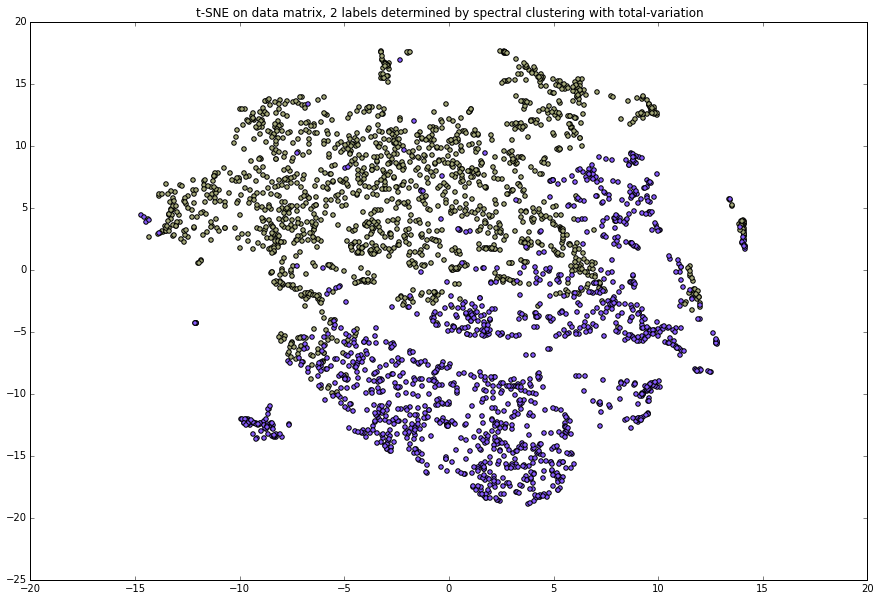

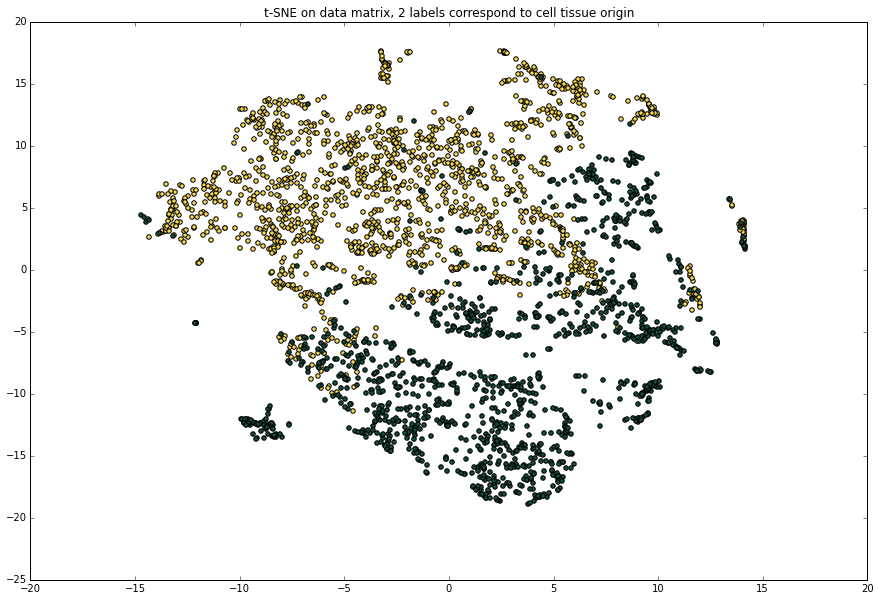

In [105]:
#Plot spectral clustering for 2 clusters
jz_plot(X_tsne,labels_spectral_l1_2)
plt.title('t-SNE on data matrix, 2 labels determined by spectral clustering with total-variation')
jz_plot(X_tsne,truth_ge4)
plt.title('t-SNE on data matrix, 2 labels correspond to cell tissue origin')

We now compute the error rates that the spectral clustering obtains when clustering classes 1 to 3 from classes 4 to 9. We observe that the performance here is similar to that using Jensen-Shannon distances.

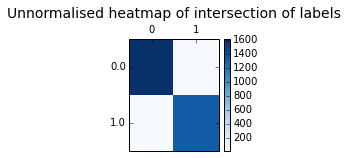

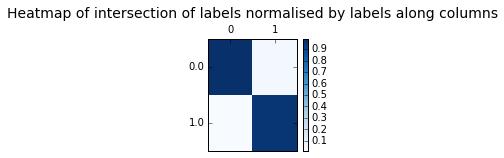

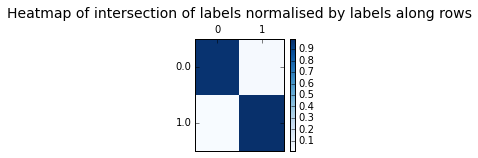

Error rates if best cluster index is picked row-wise : 2.12978369384%.
Error rates if best cluster index is picked column-wise : 2.12978369384%.
Error rates if best cluster index is picked using the Hungarian Algorithm : 2.12978369384%.


In [164]:
analyse_labeling_schemes(labels_spectral_l1_2,truth_ge4)

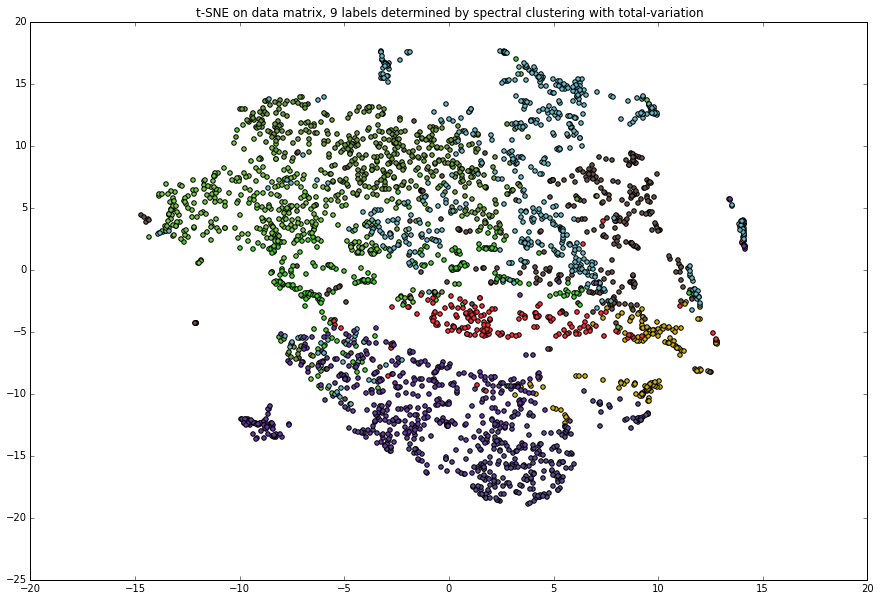

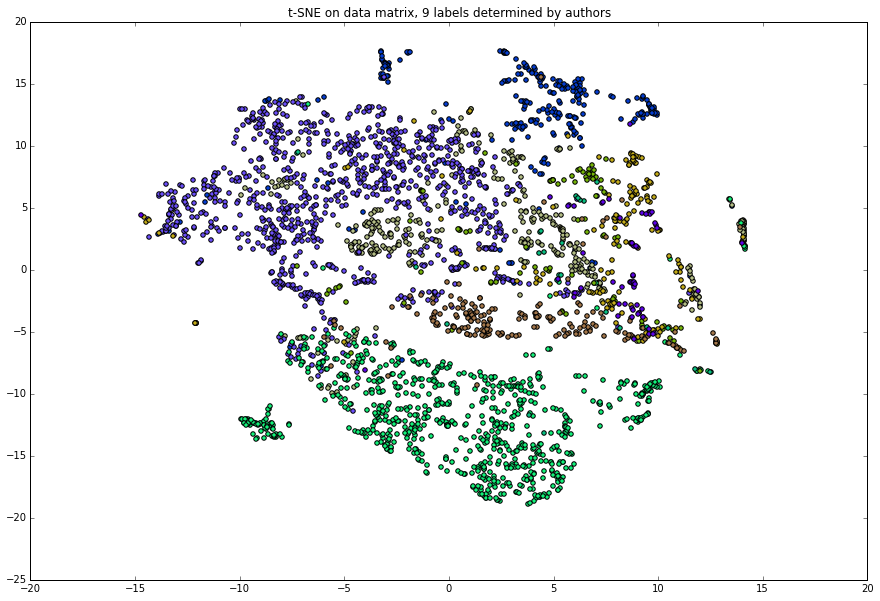

In [94]:
#Plot spectral clustering for 9 clusters
jz_plot(X_tsne,labels_spectral_l1_9)
plt.title('t-SNE on data matrix, 9 labels determined by spectral clustering with total-variation')
jz_plot(X_tsne,truth_9)
plt.title('t-SNE on data matrix, 9 labels determined by authors')

We now compute the error rates that the spectral clustering obtains when clustering all 9 classes. We observe that the performance of Total Variation distance is much worse than Jensen-Shannon.

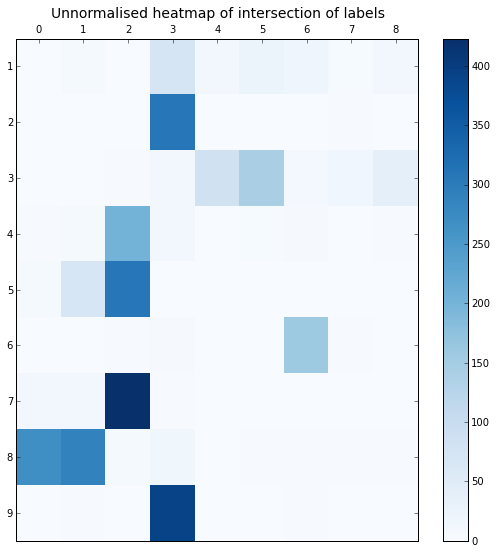

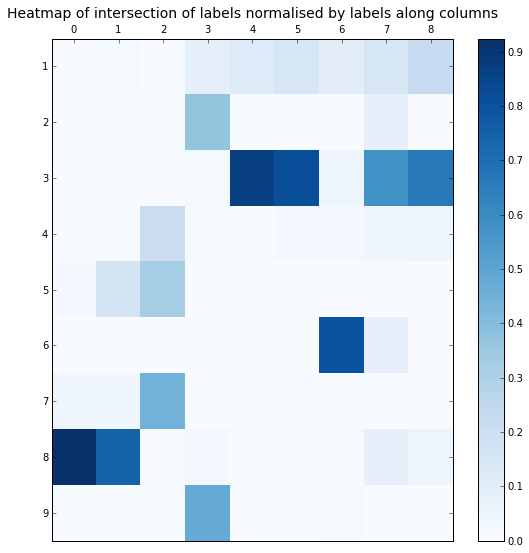

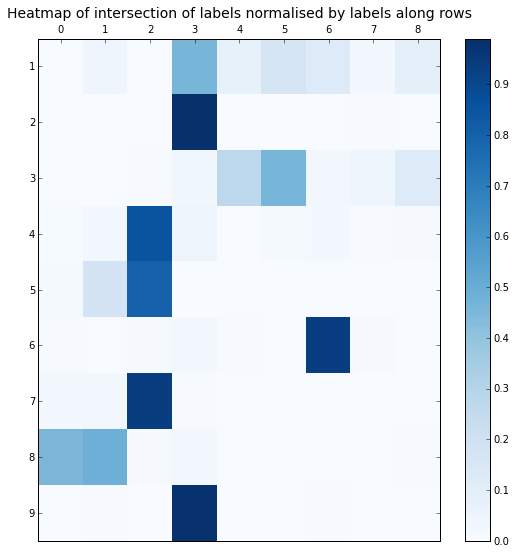

Error rates if best cluster index is picked row-wise : 39.5673876872%.
Error rates if best cluster index is picked column-wise : 23.5274542429%.
Error rates if best cluster index is picked using the Hungarian Algorithm : 51.0482529118%.


In [165]:
analyse_labeling_schemes(labels_spectral_l1_9,truth_9)

Generate labels using hierarchical clustering

In [121]:
# test hierarchical clustering.. 

z = jz_hierclust(D)
labels_hc_9 = jz_linkage_to_labels(z,9)

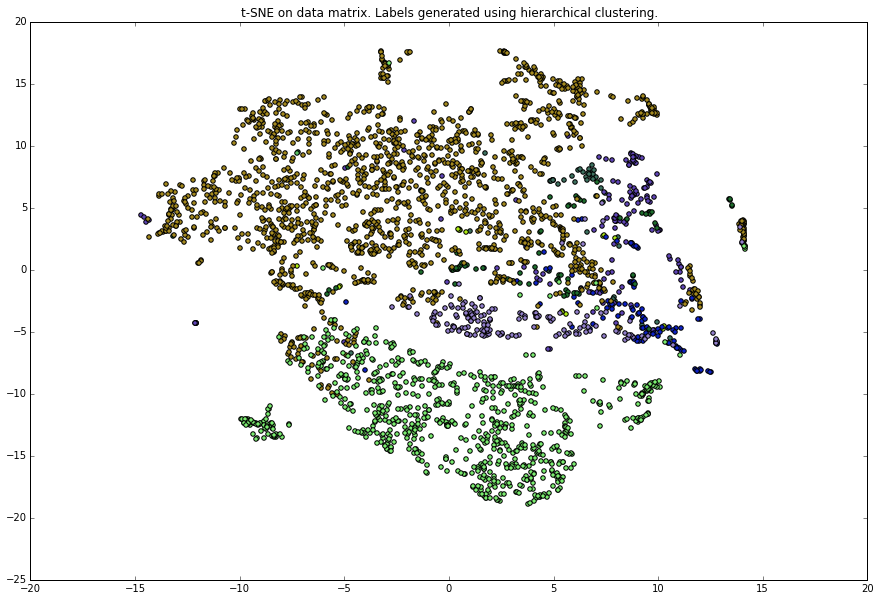

In [122]:
jz_plot(X_tsne,labels_hc_9)
plt.title('t-SNE on data matrix. Labels generated using hierarchical clustering.')

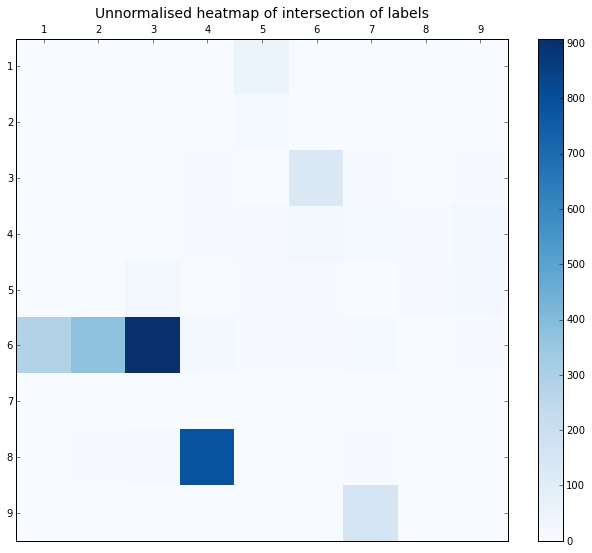

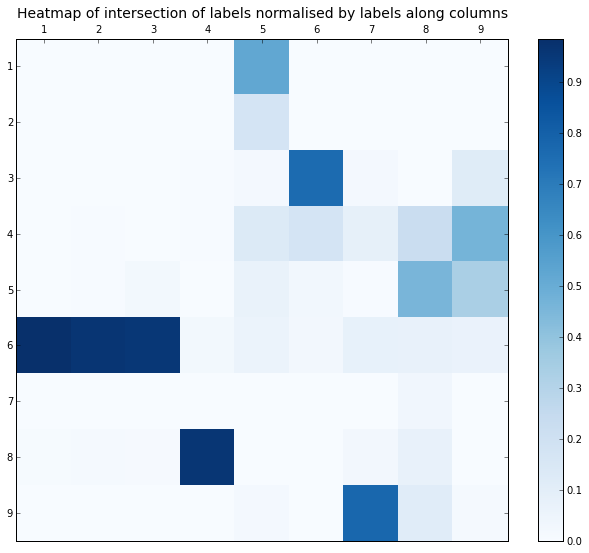

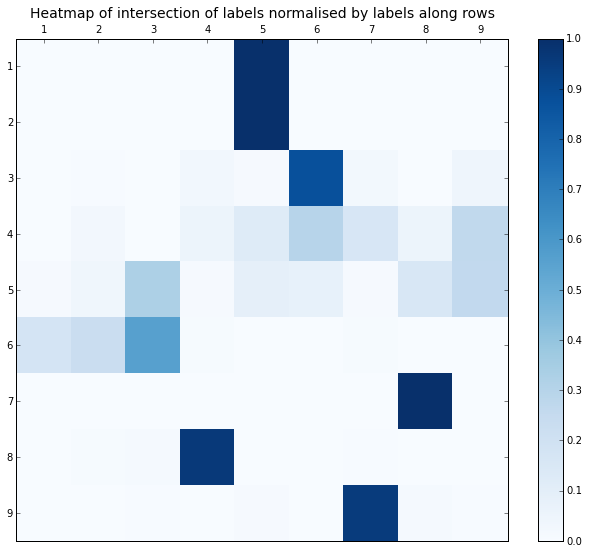

Error rates if best cluster index is picked row-wise : 8.91846921797%.
Error rates if best cluster index is picked column-wise : 29.8169717138%.
Error rates if best cluster index is picked using the Hungarian Algorithm : 30.9484193012%.


In [123]:
analyse_labeling_schemes(labels_hc_9,truth_9)

In [125]:
Gene_expr=np.loadtxt('/data/SS_RNA_seq/Zeistel_SM/Zeisel_expression_matrix.txt')

In [135]:
Gene_expr_normalised=Gene_expr.T/np.sum(Gene_expr,axis=1)

In [156]:
Sparse_gene_expr=scipy.sparse.csr_matrix(Gene_expr_normalised.T)

In [157]:
with open('/data/SS_RNA_seq/Code/Zeisel_pairwise_gene_expression.dat','wb') as outfile:
    pickle.dump(Sparse_gene_expr, outfile, pickle.HIGHEST_PROTOCOL)

In [158]:
with open('/data/SS_RNA_seq/Code/pairwise_jensen_shannon_gene_expression.dat', 'rb') as infile:
    DG = pickle.load(infile)

In [168]:
labels_spectral_gene, similarity_matrix_gene=jz_spectral(Sparse_gene_expr,9,DG)

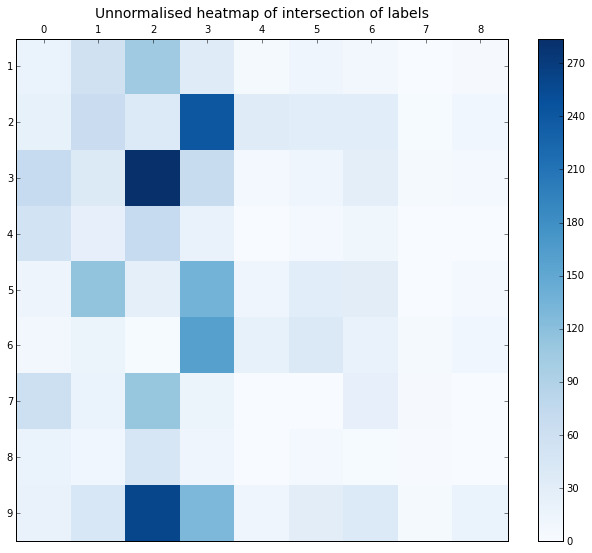

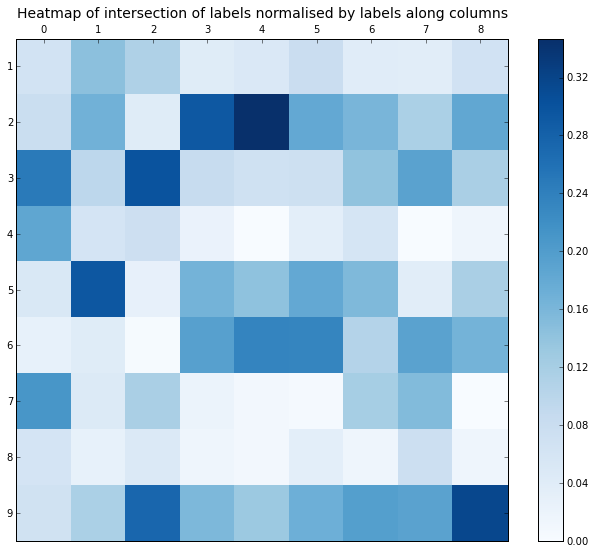

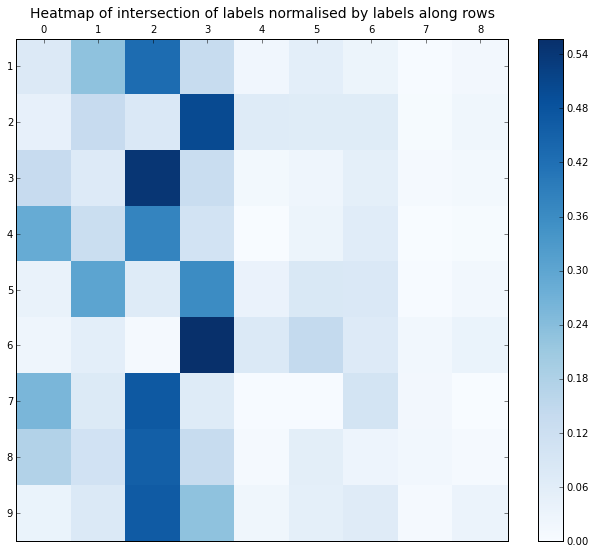

Error rates if best cluster index is picked row-wise : 71.7138103161%.
Error rates if best cluster index is picked column-wise : 52.8785357737%.
Error rates if best cluster index is picked using the Hungarian Algorithm : 73.7437603993%.


In [170]:
analyse_labeling_schemes(labels_spectral_gene,truth_9)

In [188]:
evalJS,evecJS= np.linalg.eig(np.diag(np.sum(D_sym,axis=1))-D_sym)

In [189]:
JSevals=sorted(evalJS,reverse=True)

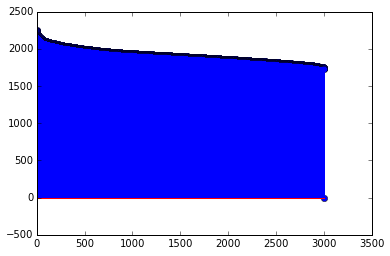

In [194]:
plt.stem(range(len(JSevals)), JSevals)
plt.show()

In [5]:
import os
eq_dir='/data/SS_RNA_seq/Zeisel/equivalence_class_subsample10'
eq_dir1='/data/SS_RNA_seq/Zeisel/equivalence_class_subsample1'
eq_dir2='/data/SS_RNA_seq/Zeisel/equivalence_class_subsample5'

In [6]:
relevant_filenames=[files for files in os.listdir(eq_dir) if files.endswith('.class')]
relevant_filenames1=[files for files in os.listdir(eq_dir1) if files.endswith('.class')]
relevant_filenames2=[files for files in os.listdir(eq_dir2) if files.endswith('.class')]


In [9]:
print len(relevant_filenames), len(relevant_filenames1), len(relevant_filenames2)

3005 3003 3002


In [10]:
files1= [x for x in relevant_filenames if x not in relevant_filenames1]
files2= [x for x in relevant_filenames if x not in relevant_filenames2]

In [11]:
print files1
print files2

['SRR1545404.class', 'SRR1545212.class']
['SRR1545773.class', 'SRR1545169.class', 'SRR1545196.class']
